In [1]:
import logging

from utils import logging as lg


lg.set_logging(logging.ERROR)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cmocean


tf.logging.set_verbosity(tf.logging.ERROR)

import math

from utils import data_provider
from utils import experiment_artifact
from notebook_utils import plot
from model import s2_network, s3_network, provider as model_provider

from heatmap_tutorial import modules, utils

plot.setup()


# Network
## S2 network ( 1st architecture )
![](https://i.imgur.com/BNLuFy2.png)
## S3 network ( 2nd architecture )
![](https://i.imgur.com/zMBa1pi.png)

# Data Preparation

In [3]:
X_train, Y_train = data_provider.get_mnist('train', dir_path='../data/mnist')
X_test, Y_test = data_provider.get_mnist('test', dir_path='../data/mnist')

In [4]:
X_train_2d = np.copy(X_train.reshape((-1,28,28)))
X_test_2d = np.copy(X_test.reshape((-1,28,28)))

In [5]:
x_from_tutorial, y_from_tutorial = utils.getMNISTsample(N=12,path='../data/mnist',seed=1234)
x_from_tutorial = x_from_tutorial.reshape(-1,28,28)

# Define functions

In [6]:
def plot_heatmap(data_idx, s2_models,  s3_models, colorbar=False, suptitle='', highlight_plots=[]):
    global count
    
    no_cols = np.max([len(s2_models), len(s3_models)]) + 1
    plt.figure(figsize=(5*no_cols,12))
    plt.suptitle(suptitle)

    x = X_test_2d[data_idx,:,:].reshape(1,28,28)

    y_target = np.argmax(Y_test[data_idx])

    plt.subplot(2,no_cols,1)
    plt.title('Data Label %d' % y_target)
    plt.imshow(x.reshape(28,28))
    if colorbar:
        plt.colorbar()

    count = 2
    def plot_models(models):
        global count
        for f in models:
            ax = plt.subplot(2,no_cols,count)
            model = model_provider.load(f)

            pred_label, heatmap = model.lrp(x, debug=False)
            plt.title('%s\n%s\n%s\n(keep_prob=%.2f acc=%.4f)\n no. variables %d | pred %d' %
                      (model._.architecture_name, model._.experiment_name, model._.architecture, 
                       model._.keep_prob, model._.accuracy, 
                       model.dag.no_variables(), pred_label[0]))
            plt.imshow(heatmap[0,:,:], cmap='Reds')
            
            if count in highlight_plots:
                for axis in ['top','bottom','left','right']:
                    ax.spines[axis].set_linewidth(5)

            if colorbar:
                plt.colorbar()
            count = count + 1
            if count-1 % no_cols == 0:
                count + 1 # skip 1st col
            
    plot_models(s2_models)
    count = count + 1 # skip 1st col for 2nd row
    plot_models(s3_models)
    
    plt.show() 

In [7]:
def plot_layer(model, layer_name, col_selector=None, seed = 1, nrows=1, ncols=40, img_shape=(28,4),
               no_plots=40,row_size=6, col_size=0.76, keep_scale=True, lazy_show=False, cmap='RdBu'):

    model_obj = model_provider.load(model)

    with model_obj.get_session() as sess:
        w = getattr(model_obj.dag, layer_name).W.eval(session=sess)
        
    w_selected = w[:col_selector, :].T

    
    vmin = np.min(w_selected)
    vmax = np.max(w_selected)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(col_size*ncols,row_size*nrows))
    np.random.seed(2)
    indices = sorted(np.random.choice(w_selected.shape[0], size=no_plots, replace=False))
    for i, ax in zip(indices,axes.flat):

        if keep_scale:
            im = ax.imshow(w_selected[i,:].reshape(*img_shape), cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = ax.imshow(w_selected[i,:].reshape(*img_shape), cmap=cmap)
        ax.axis('off')

        ax.set_title(i)

    plt.suptitle('%s : %s neuron weights | %s %s (no. variables %d ) | (keep_prob %.4f, acc %.4f, min %.4f, vmax %.4f)' % (
                model_obj._.architecture_name,
                layer_name,
                model_obj._.experiment_name,
                model_obj._.architecture,
                model_obj.dag.no_variables(),
                model_obj._.keep_prob,
                model_obj._.accuracy,
                vmin,
                vmax
    ))


    if not lazy_show:
        plt.show()
        
def plot_layer_from_models(models, layer, ncol=50, nrow=1, img_shape=(28,14), row_size=2.5):
    for m in models:
        plot_layer(m, layer, col_selector=None, img_shape=img_shape, no_plots=ncol*nrow, ncols=ncol, nrows=nrow,
               col_size=1, row_size=row_size)

In [8]:
def plot_digits(m, data):
    total = data.shape[0]
    plt.figure(figsize=(20,3))
    
    if m is not None:
        preds, heatmaps = m.lrp(data, debug=False)
    for i in range(total):
        plt.subplot(1,12,i+1)
        if m is not None:
            pred, heatmap = preds[i], heatmaps[i,:,:]
            plt.title('Pred %d' % pred)
        else:
            heatmap = data[i,:]
            
        plt.imshow(heatmap, cmap="Reds")
        plt.xticks([])
        plt.yticks([])
        
    if m is not None:
        plt.suptitle('Heatmaps from %s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                     (m._.architecture_name,
                      m._.architecture,
                      m._.experiment_name,
                      m.dag.no_variables(),
                      m._.optimizer,
                      m._.accuracy,
                      m._.keep_prob
                     ))

def plot_digit_models(models):
    
    plot_digits(None, x_from_tutorial)
    
    for m in models:
        m = model_provider.load(m)
        plot_digits(m, x_from_tutorial)
        
    plt.show()

# Visualization

## Seq 1 ( 28 cols feed )

In [9]:
seq_1_models = [
    '../experiment-results/sprint-6/s3-seq-1---2017-11-04--16-30',
    '../experiment-results/sprint-6/s3-seq-1---2017-11-04--16-42'
]

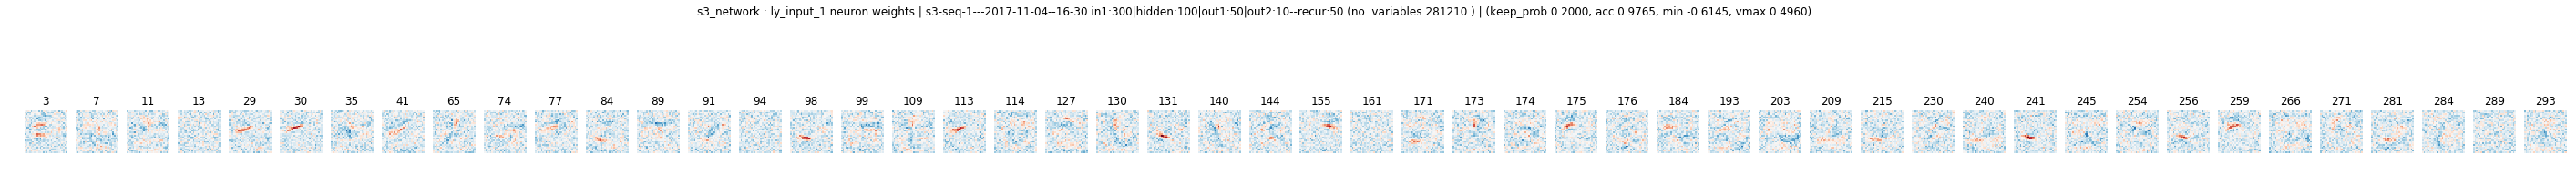

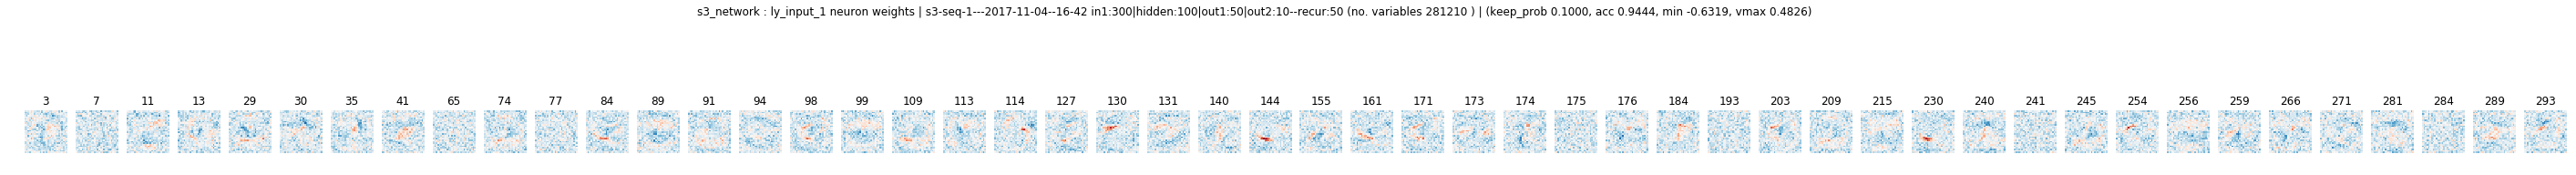

In [10]:
plot_layer_from_models(seq_1_models, 'ly_input_1', img_shape=(28,28), row_size=4)

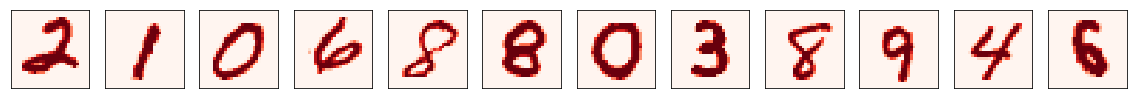

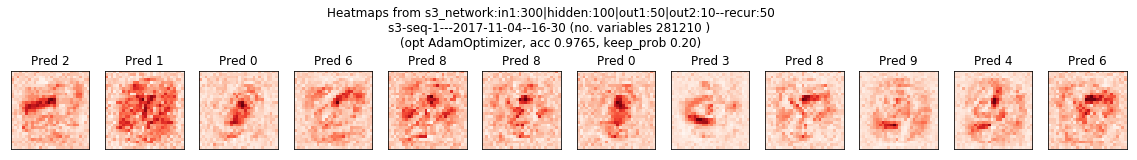

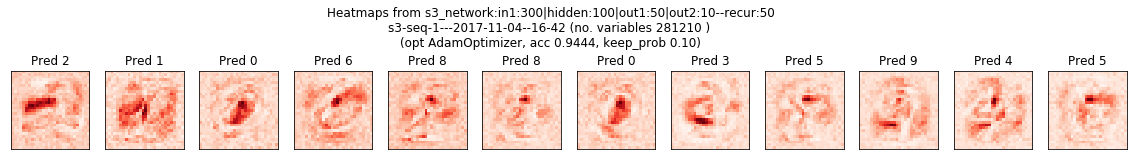

In [11]:
plot_digit_models(seq_1_models)

## Seq 2 ( 14 cols feed )

## Seq 4 ( 7 cols feed )

In [42]:
seq_4_models = [
    '../experiment-results/sprint-6/s2-seq-4---2017-11-07--21-06-35',
    '../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02',
    '../experiment-results/sprint-6-improve-dropout-ly/s2-seq-4---2017-11-11--16-45-39',
    '../experiment-results/sprint-6-improve-dropout-ly/s3-seq-4---2017-11-09--20-36-34',
    '../experiment-results/sprint-6-improve-dropout-ly/s3-seq-4---2017-11-09--21-01-27',
    '../experiment-results/sprint-6-improve-dropout-ly/s3-seq-4---2017-11-09--21-29-46',
]

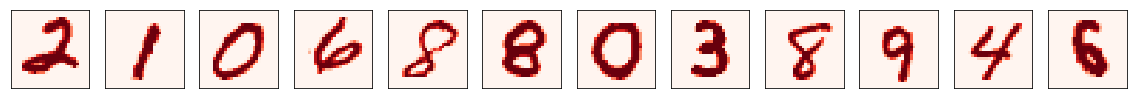

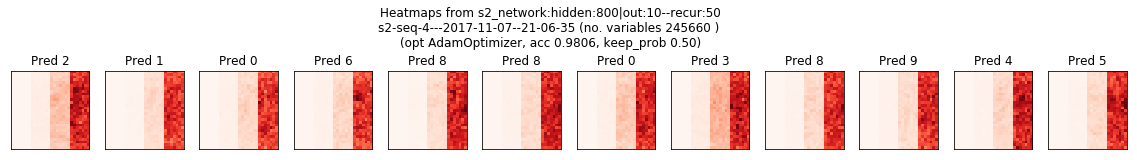

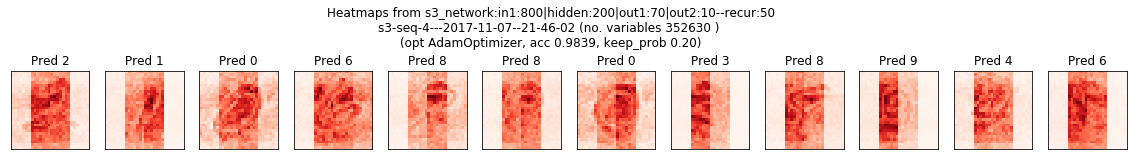

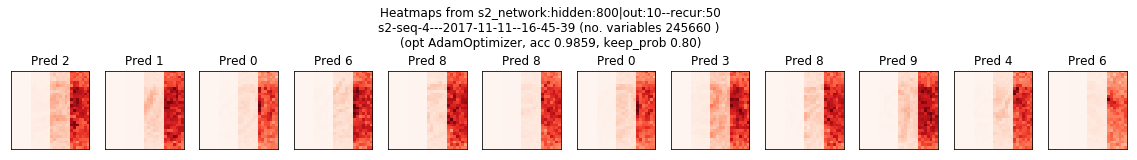

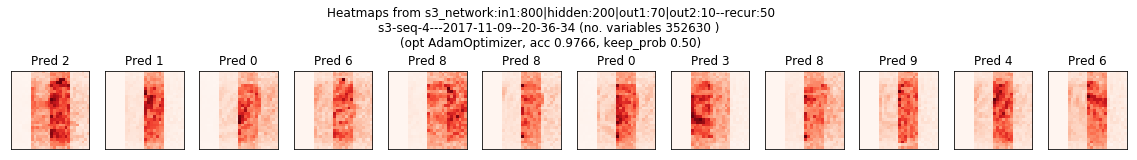

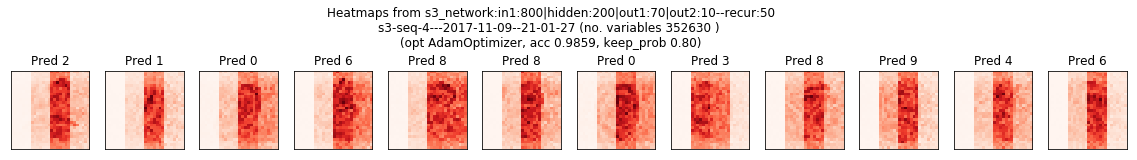

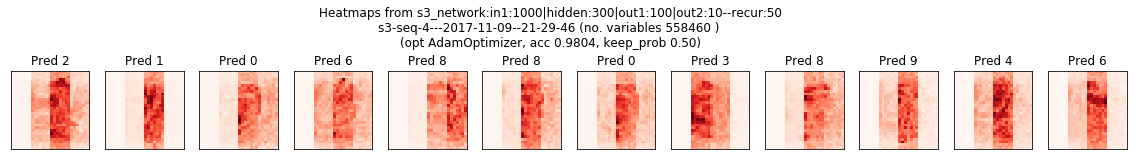

In [43]:
plot_digit_models(seq_4_models)

## Seq 7 ( 4 cols feed )

In [45]:
seq_7_models = [
#     '../experiment-results/sprint-6/s2-seq-7---2017-11-06--07-13-22', # TODO : replace it with 800:10-50
    '../experiment-results/sprint-6/s2-seq-7---2017-11-07--21-30-19',
    '../experiment-results/sprint-6/s2-seq-7---2017-11-07--21-01-07',
#     '../experiment-results/sprint-6/s3-seq-7---2017-11-05--22-31-13',
    '../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22',
    '../experiment-results/sprint-6/s3-seq-7---2017-11-05--23-00-40',
    
    '../experiment-results/sprint-6-improve-dropout-ly/s2-seq-7---2017-11-12--09-31-18',
    '../experiment-results/sprint-6-improve-dropout-ly/s3-seq-7---2017-11-09--23-46-09',
]

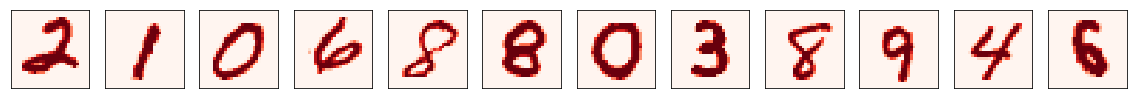

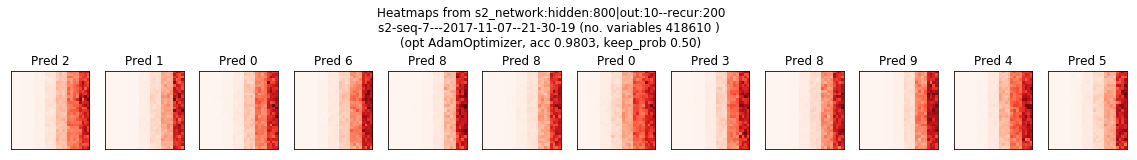

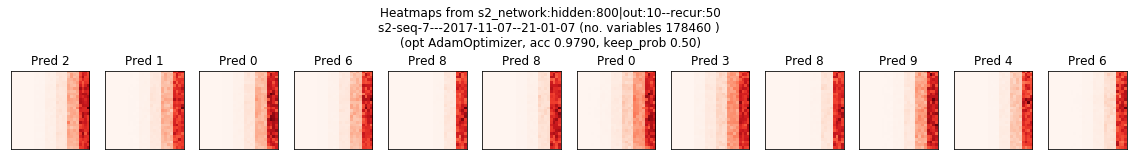

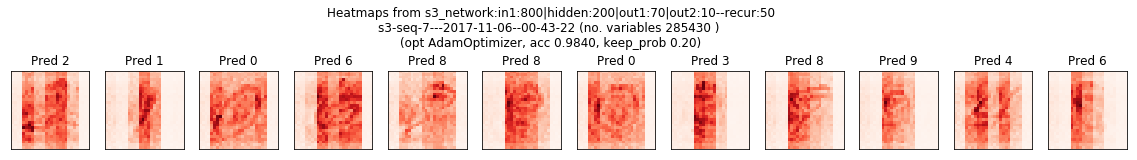

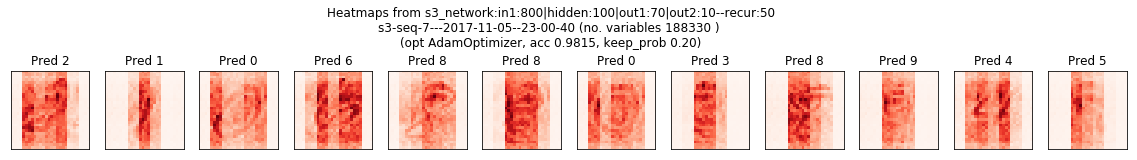

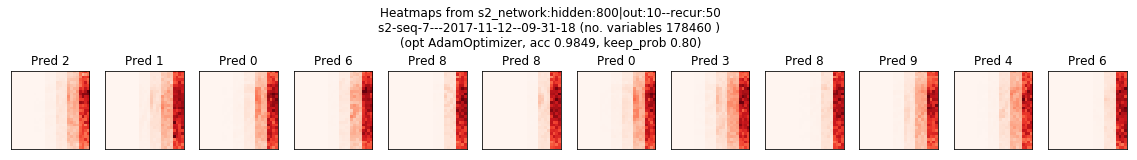

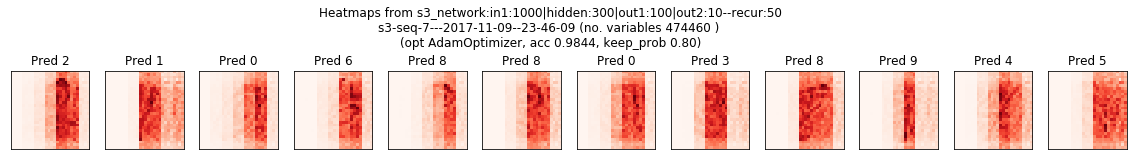

In [46]:
plot_digit_models(seq_7_models)

In [16]:
# plot_layer(seq_7_models[0], 'ly_input', col_selector=28*4, img_shape=(28,4), row_size=3.5, col_size=0.5, keep_scale=True)

In [17]:
# plot_layer(seq_7_models[1], 'ly_input', col_selector=28*4, img_shape=(28,4), row_size=3.5, col_size=0.5, keep_scale=True)

In [18]:
# plot_layer(seq_7_models[2], 'ly_input_1', img_shape=(28,4), row_size=3.5, col_size=0.5, keep_scale=True)

## Seq 14 ( 2 cols feed )

In [57]:
seq_14_models = [
#     '../experiment-results/sprint-6/s2-seq-14---2017-11-07--23-17-58',
#     '../experiment-results/sprint-6/s2-seq-14---2017-11-08--08-25-42',
    '../experiment-results/sprint-6/s3-seq-14---2017-11-06--07-59-10',
#     '../experiment-results/sprint-6/s3-seq-14---2017-11-06--23-19-23',
    '../experiment-results/sprint-6-improve-dropout-ly/s3-seq-14---2017-11-11--16-39-51',
#     '../experiment-results/sprint-6-improve-dropout-ly/s3-seq-14---2017-11-12--09-44-25',
#     '../experiment-results/sprint-6-improve-dropout-ly/s3-seq-14---2017-11-12--12-53-44',
#     '../experiment-results/sprint-6-improve-dropout-ly/s3-seq-14---2017-11-12--15-02-37',
#     '../experiment-results/sprint-6-s3-no-dropout-in2cell/s3-seq-14---2017-11-12--16-54-46',
    '../experiment-results/sprint-6-s3-no-dropout-in2cell/s3-seq-14---2017-11-12--17-39-05',
    '../experiment-results/sprint-6-s3-dropout-increase-linear/s3-seq-14---2017-11-12--18-41-18',
    '../experiment-results/sprint-6-s3-dropout-input-layers/s3-seq-14---2017-11-12--19-17-37',
]

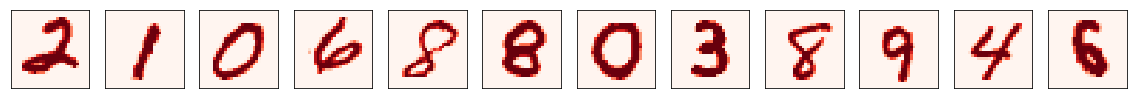

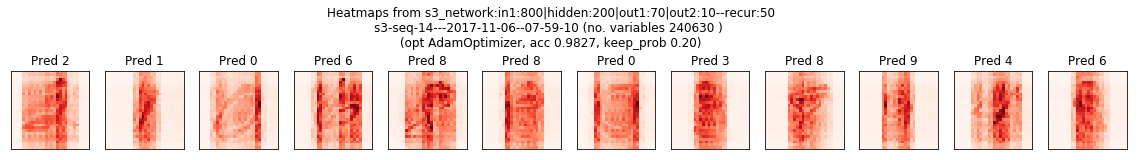

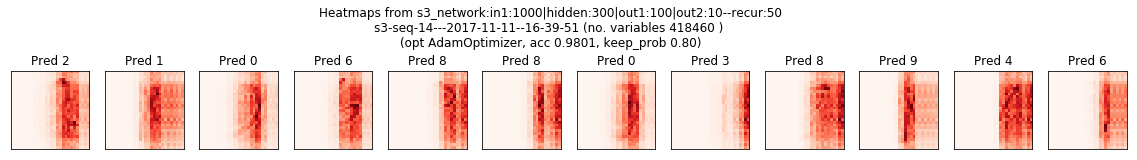

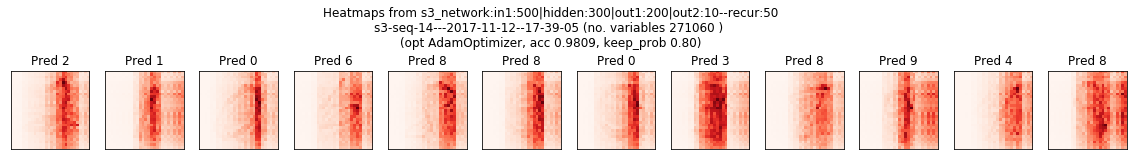

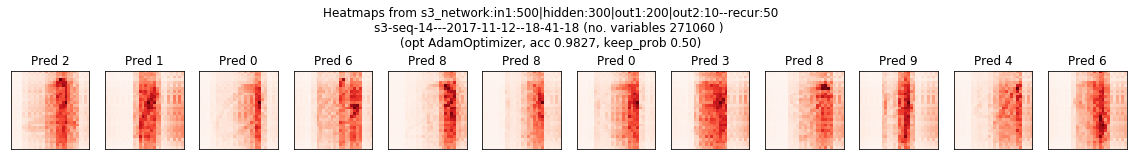

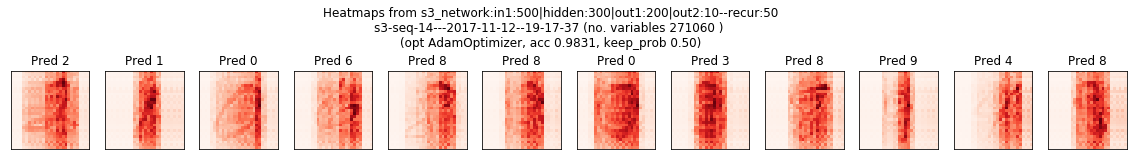

In [58]:
plot_digit_models(seq_14_models)

In [21]:
# plot_layer(seq_14_models[0], 'ly_input_1', img_shape=(28,2), row_size=4.5, col_size=0.5, keep_scale=True)

## Seq 28 ( 1 cols feed )

In [22]:
seq_28_models = [
    '../experiment-results/sprint-6/s3-seq-28---2017-11-07--00-03-00',
    '../experiment-results/sprint-6/s3-seq-28---2017-11-07--22-48-57',
    '../experiment-results/sprint-6/s3-seq-28---2017-11-08--00-01-34',
    '../experiment-results/sprint-6/s3-seq-28---2017-11-08--14-12-17',
]

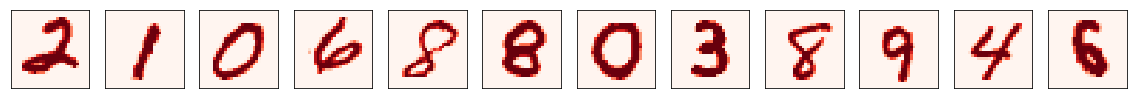

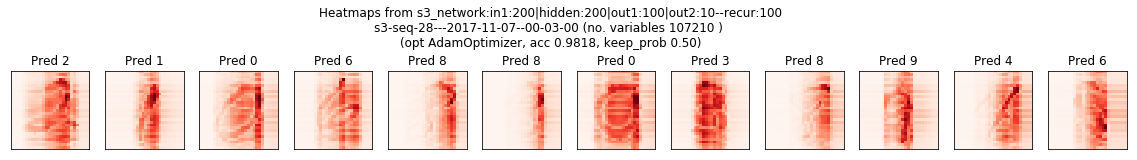

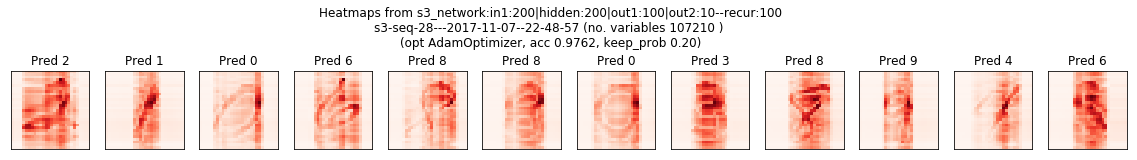

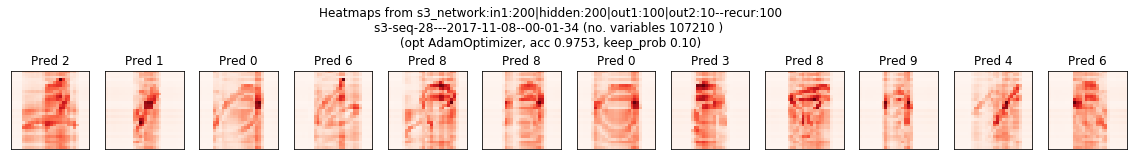

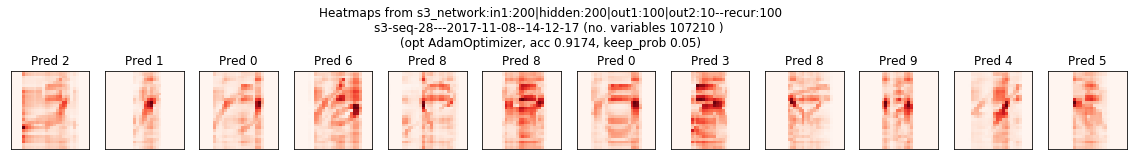

In [23]:
plot_digit_models(seq_28_models)

In [24]:
# plot_layer(seq_28_models[0], 'ly_input_1', img_shape=(28,1), row_size=4.5, col_size=0.5, keep_scale=True)

## Effect of dropout

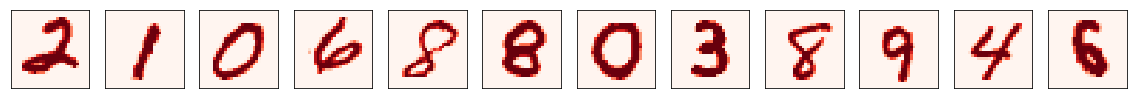

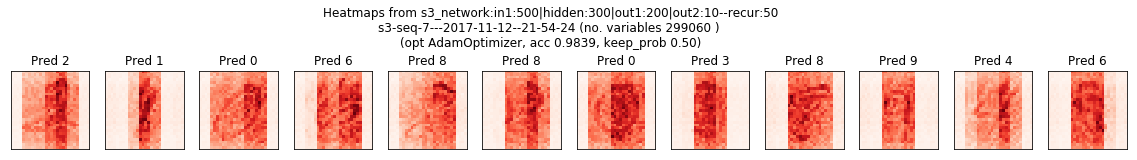

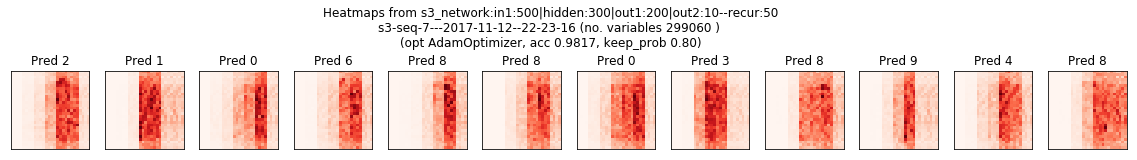

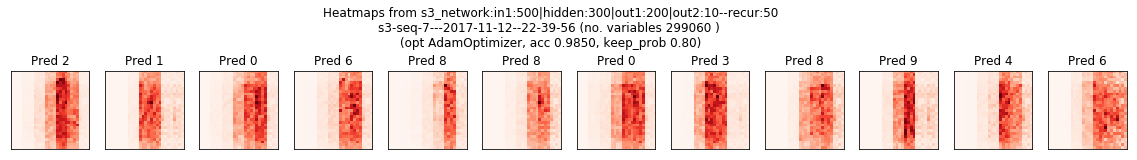

In [68]:
seq_dropout_effect_models = [
    '../experiment-results/sprint-6-s3-dropout-at-1/s3-seq-7---2017-11-12--21-54-24',
    '../experiment-results/sprint-6-s3-dropout-at-12/s3-seq-7---2017-11-12--22-23-16',
    '../experiment-results/sprint-6-s3-dropout-at-1234/s3-seq-7---2017-11-12--22-39-56',
 ]
plot_digit_models(seq_dropout_effect_models)